In [1]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d adityajn105/flickr8k

!unzip -q flickr8k.zip

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Embedding, GRU, Concatenate, Reshape, Dropout, add
import pandas as pd
import re
import nltk
import pickle
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers

In [ ]:
BASE_DIR = 'Dataset'
WORKING_DIR = ''

In [ ]:
# Load EfficientNetV2B0 model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
# Create a sequential model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

In [ ]:
# Extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

In [ ]:
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features
    feature = model.predict(image, verbose=0)

    # Get image ID
    image_id = img_name.split('.')[0]

    # Store feature
    features[image_id] = feature

In [ ]:
# Store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# Load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# Create mapping of image to captions
mapping = {}

In [ ]:
# Process lines
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)

    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

In [ ]:
# Define the clean function
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-zA-Z]', ' ', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
# Before preprocess of text
print(mapping['1000268201_693b08cb0e'])

# Preprocess the text
clean(mapping)

# After preprocess of text
print(mapping['1000268201_693b08cb0e'])

In [ ]:
# Collect all captions
all_captions = [caption for key in mapping for caption in mapping[key]]

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Get the maximum length of the caption
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
# Get the list of image IDs
image_ids = list(mapping.keys())

In [ ]:
# Split the data into train and test sets
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from tensorflow.keras.utils import plot_model

# Encoder model
inputs1 = Input(shape=(1280,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers using GRU
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)


In [ ]:
# train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('best_model.h5')


In [ ]:
# Function to convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# Generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [ ]:
model.summary()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    # Display the actual captions
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Embedding, GRU, Concatenate, Reshape, Dropout, add
import pandas as pd
import re
import nltk
import pickle
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers

In [2]:
BASE_DIR = 'Dataset'
WORKING_DIR = ''

In [3]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [4]:
# Create mapping of image to captions
mapping = {}

In [5]:
# Process lines
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)

    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [6]:
# Define the clean function
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-zA-Z]', ' ', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [7]:
# Before preprocess of text
print(mapping['1000268201_693b08cb0e'])

# Preprocess the text
clean(mapping)

# After preprocess of text
print(mapping['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [8]:
# Collect all captions
all_captions = [caption for key in mapping for caption in mapping[key]]

In [9]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [10]:
# Get the maximum length of the caption
max_length = max(len(caption.split()) for caption in all_captions)

In [11]:
# Get the list of image IDs
image_ids = list(mapping.keys())

In [12]:
# Split the data into train and test sets
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [14]:
BASE_DIR = 'Dataset1'
WORKING_DIR = ''

In [15]:
# Load EfficientNetV2B0 model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
# Create a sequential model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

In [17]:
# Extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

In [19]:
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features
    feature = model.predict(image, verbose=0)

    # Get image ID
    image_id = img_name.split('.')[0]

    # Store feature
    features[image_id] = feature

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
# Store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features1.pkl'), 'wb'))

In [21]:
# Load features from pickle
with open(os.path.join(WORKING_DIR, 'features1.pkl'), 'rb') as f:
    features = pickle.load(f)

In [22]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('best_model.h5')


In [23]:
# Function to convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [24]:
# Generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [25]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)


    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

--------------------Predicted--------------------
startseq two dogs running through the grass endseq


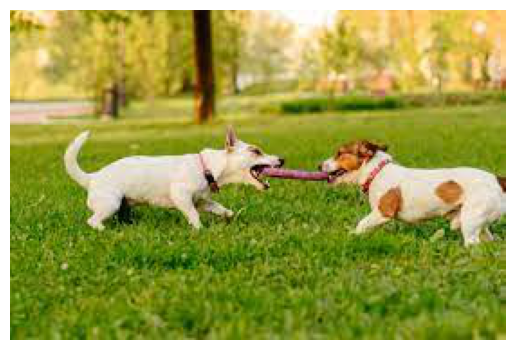

--------------------Predicted--------------------
startseq dog jumps up to catch tennis ball thrown endseq


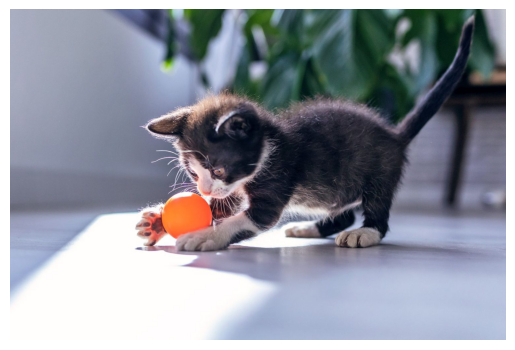

KeyError: 'kittu'

In [39]:
generate_caption("dog.jpeg")
generate_caption("cat.jpg")
generate_caption("kittu.jpeg")
generate_caption("d.jpeg")










